In [12]:
# Event list : ftp://ftp.swpc.noaa.gov/pub/warehouse/
import shutil
import os
import pandas as pd
from os.path import exists
import glob
from sys import stdout
from time import sleep
import sys
import matplotlib.pyplot as plt 
from astropy.io import fits
import numpy as np
import glob

In [ ]:
class variables:
    def __init__(self, **kwargs):
        
        self.s = "/"
        self.types = ["I","II","III","IV","V","VI"]
        self.categories = ["1","2","3"]
        self.year = kwargs["year"]
        self.month = kwargs["month"]
        self.day = kwargs["day"]
        self.dst = kwargs["dst"]
        self.src = kwargs["src"]   

In [ ]:
class Read_events:
    
    def __init__(self, d):
        self.path = d.dst
        self.year = str(d.year)
        self.year_int = d.year
        self.path2 = self.path+"Event list/" + self.year+"_events/*.txt"
        self.types = d.types
        self.categories = d.categories
        self.s = d.s
        self.path1 = d.dst
        self.month = d.month
        self.day = d.day
        self.source  = d.src
        
    def extract_files(self): # only to extract .tar.gz file, it can be done with winrar or any other software manualy 
        # archive = self.year + '_events.tar.gz'
        # tar = tarfile.open(archive, "r:gz")# download and put archive 
        # # file in the working directory   
        # for member in tar.getmembers():
        #     #print "Extracting %s" % member.name
        #     tar.extract(member, path='')  
        return False
    
    def find(self,name, path):#return root dir and name of a given file
        for root, dirs, files in os.walk(path):
            if name in files:
                return os.path.join(root, name) 
            
    def fit_files_list(self):#this function save a list of all '.fit' files present in a given directory, in this case E drive.
        fs = []
        actual = []
        fd = []
        for root, dirs, files in os.walk(self.source): # change drive name 
            # select file name
            for file in files:
                # check the extension of files
                if file.endswith('.fit'):
                    # print whole path of files             
                    fs.append(file.split('_'))
                    fd.append(file)
                    actual.append(file.split('.'))
        d = pd.DataFrame(fs)
        ds = pd.DataFrame(actual)
        d[3],d[4] = ds[0] , fd
        d.drop(d.index[d[1].isnull()], inplace = True)
        d[5] = pd.to_datetime(d[1]).dt.date
        d[1] = pd.to_datetime(d[1] + d[2])
        d = d.set_index(d[1])
        d.drop_duplicates(subset=[4],inplace = True)
        d.index = d.index.floor('60min')
        d.drop(labels = [1],inplace = True, axis = 1)
        d.drop(d.index[d[3].str.contains(" ")], inplace = True)
        # d.to_csv("E:/CALLISTO/All_files_list.csv" , index = True)
        return d
    
    def read_files(self):# read extracted files, combine them in a dataframe
        liste = glob.glob(self.path2)
        df1 = []
        for x in range (len(liste)-1):
            #           Event   Begind    Max       End     Obs      
            colspecs = [(0, 6),(10, 16), (18, 22),(27,32),(34,37),
                        (38,40),(40,46),(48,52),(56,63),(65,73)]
            #               Q     Type   Loc     Cat/type
            df = pd.read_fwf(liste[x], colspecs=colspecs, header = None)
            df.drop(
                    labels = [0,1,2,3,4,5,6,7,8,9,10,11],
                    axis = 0,
                    inplace = True)
            df.drop(
                df.index[df[1].isnull()],
                inplace = True)
            xf = liste[x].split("\\")
            xf = xf[1].split(".")
            xf = xf[0].replace("events","")
            df[10] = xf
            df
            df1.append(df)
            continue
        return df1
    
    def search(self,index, category):#search index in parameters is for the end and begin timing column
        dfs = self.read_files()
        final = pd.concat(dfs)
        final.drop(
                final.index[final[index].isnull()],
                inplace = True)
        final.drop(
            final.index[final[index].str.contains("[a-zA-Z]")],#for removing alphabets
            inplace = True
            )
        final[11] = final[10] + final[index]
        final[11] = pd.to_datetime(final[11])
        cat_3 = final[final[8] == category]
        cat_3 = cat_3.set_index(cat_3[11])
        cat_3 =  cat_3.between_time('00:30', '15:00')
        cat_3.index = cat_3.index.floor('60min')
        return cat_3
    
    def category(self,category):#return dataframe of category passed in the parameter
        final_df = pd.concat([self.search(1,category),self.search(3,category)])
        final_df.drop(labels = [11], axis = 1, inplace = True)
        final_df.drop_duplicates(inplace = True)
        final_df
        return final_df
    
    def filter_by_time(self,g,category):# return the list of files present in the noaa solar events 
        d = g
        d.index = pd.to_datetime(d.index)
        cat = self.category(category).index
        # d.index.isin(cat)# index number
        file = d[d.index.isin(cat)]    
        return file       
    
    def categorize(self):#access types and categories, and move files in directory tree pattern
        g = self.fit_files_list()
        counter = 0
        for t in self.types:
            for c in self.categories:
                list_1 = self.filter_by_time(g,t+self.s+c)
                length = len(list_1)
                path = self.path1+self.s+self.year+self.s+t+self.s+c+self.s+"Data"
                if exists(path) == False and length:
                    os.makedirs(path)
                for x in range (len(list_1)):     
                    src = self.find(list_1[4][x], self.source)#Source Path
                    dst = path +'/'+list_1[4][x]# Destination path
                    shutil.copy(src, dst)
                    counter +=1
                    stdout.write("\r%d Files copied " % counter)
                    stdout.flush()
                    sleep(0.01)
                    continue
                    return 0   

In [ ]:
class copy_files:
    def __init__(self, d):
        self.s = d.s
        self.year = d.year
        self.month = d.month
        self.day = d.day
        self.path = d.dst
        self.fit_files_list = Read_events(d).fit_files_list
        self.find = Read_events(d).find
        self.source = d.src
  
    def copy(self, li,path):
        counter = 0
        path2 = path
        if exists(path2) == False:
            os.makedirs(path2)   
        for x in range (len(li)):     
            src = self.find(li[4][x], self.source)#Source Path
            dst = path2 +'/'+li[4][x]# Destination path
            shutil.copy(src, dst)
            counter +=1
            stdout.write("\r%d Files copied " % counter)
            stdout.flush()
            sleep(0.01)
            continue   

    def yearly(self):
        path2 = self.path+str(self.year)+self.s+"All Files"
        li = self.fit_files_list()
        li = li[li.index.year == self.year]
        self.copy(li,path2)        

    def monthly(self):
        path2 = self.path+self.year+self.s+str(self.month)+ self.s+"Data"
        li = self.fit_files_list()
        li = li[li.index.year == self.year]
        li = li[li.index.month == self.month]
        self.copy(li, path2)

    def specified_date(self):
        path2 = self.path+str(self.year)+self.s+str(self.month)+ self.s+str(self.day)+self.s+"Data"
        li = self.fit_files_list()
        li = li[li.index.year == self.year]
        li = li[li.index.month == self.month]
        li = li[li.index.day == self.day]
        self.copy(li, path2)
        
    def date_range(self,start, end): 
        path = self.path+"Daily_Overview"+self.s+start +"_to_" + end+ self.s+self.s+"Data"
        per = pd.date_range(start = start, end =end, freq ='D')
        df = pd.DataFrame()
        df[1] = per.date
        df = df.set_index(df[1])
        li = self.fit_files_list()
        df = li[li[5].isin(df.index)]
        return df,path   
    
    def folder_maker(self,d,path):
        while len(d)>0:
            x = d[d[5] == d[5][1]] 
            date = x[5][1].strftime("%m-%d-%Y")#pls make it (YY-mm-dd) for future use
            path1 = path +self.s+date
            if exists(path1) == False:
                os.makedirs(path1)  
            self.copy(x,path1)
            d = d.loc[d.index.difference(x.index)]   

In [13]:
class Daily_Overview:
    def __init__(self, **kwargs):        
        self.path = kwargs["data_path"]
        self.ID = kwargs["ID"]
        self.FC = kwargs["FC"]
        self.dst = kwargs["dst"]
        
    def filter(self, path, date):
        FCe = '_'+self.FC+'.fit'
        myfilter= path+self.ID+'_'+date[0:4]+date[5:7]+date[8:10]+'*'+FCe+'*'
        liste = glob.glob(myfilter)
#         liste.sort()     
        return liste
    
    def files(self):
        list = []
        for root, dirs, files in os.walk(self.path):
            list.append(dirs)
        list = list[0]
        for i in range(len(list)):
            path = self.path +"\\"+ list[i]+"\\"
            date = list[i]
            liste = self.filter(path, date)
            path2 = self.dst+"/"+date[0:4]+date[5:7]+date[8:10]+'.png'
            if exists(path2) == False:
                print(path2)
                try:
                    self.daily_overview(liste,date) # date-code, instrument-code, focus-code
                except:
                    print ("Error, most probably one or more corrupt FIT-file(s): ",sys.exc_info())
        return False

    def daily_overview(self,liste,date):  

        fig, axs = plt.subplots(4, 16, figsize=(21,8), sharex=True, sharey=True)  
        axs = axs.flatten() #from grid to flat list
        FCe = '_'+self.FC+'.fit'
#         print(liste[0], date,FCe)
#         myfilter= path+self.ID+'_'+date[0:4]+date[5:7]+date[8:10]+'*'+FCe+'*'
#         liste = glob.glob(myfilter)
#         liste.sort()
        for ffile in liste:
            if FCe in ffile:
                hdu = fits.open(ffile)
                S = hdu[0].data
                n  = 30*4 # position in time for background analysis
                dn = 7 # number of spectra to average
                spec = S[:,n:n+dn] # take a slice of a clean part
                size = spec.shape
                columns = size[0]
                background = np.mean(spec,axis=1).reshape(columns,1)
                data = S - background
                data = data.clip(-1,50) # 30 adjust color-map (0dB = blue)
                freq = hdu[1].data[0][1] # frequency axis
                date = hdu[0].header['DATE-OBS']
                Thour = int(hdu[0].header['TIME-OBS'].split(":")[0])
                Tmin  = int(hdu[0].header['TIME-OBS'].split(":")[1])
                p = int(int(Thour*60+Tmin)/15 + 0.5)
                extent = (0,1, freq[-1], freq[0])
                axs[p].imshow(data, aspect="auto", extent=extent)
                axs[p].set_xticks([])                #axs[p].axis('off')
                hdu.close()
                
        txt = '00            15             30             45              '
        xaxistxt = txt + txt + txt + txt + txt 
        fig.text(0.12, 0.07, xaxistxt, ha='left',fontsize=10.5)
        fig.text(0.055, 0.5, 'Frequency [MHz]', va='center', rotation='vertical', fontsize=15)
        fig.text(0.91, 0.84, '00-03UT', va='center', rotation='horizontal', fontsize=15)
        fig.text(0.91, 0.71, '04-07UT', va='center', rotation='horizontal', fontsize=15)
        fig.text(0.91, 0.58, '08-11UT', va='center', rotation='horizontal', fontsize=15)
        fig.text(0.91, 0.45, '12-15UT', va='center', rotation='horizontal', fontsize=15)
        fig.text(0.91, 0.32, '16-19UT', va='center', rotation='horizontal', fontsize=15)
        fig.text(0.91, 0.19, '20-23UT', va='center', rotation='horizontal', fontsize=15)
        fig.subplots_adjust(wspace=0.001, hspace=0.1)
        save_path = self.dst+"/"+date[0:4]+date[5:7]+date[8:10]+'.png'
        plt.suptitle("Full day spectra "+date+" station: "+self.ID+' with focus-code: '+self.FC, size=16)
        plt.savefig(save_path)
        print(save_path)
        plt.show()

In [14]:
arguments = {
       "data_path":"E:\\CALLISTO\\Daily_Overview\\01-01-2022_to_06-30-2022\\Data",
        "FC":"59",
        "ID":"SONPK",
        "dst" : "E:\CALLISTO\Daily_Overview\\01-01-2022_to_06-30-2022\Plots_SONPK"
} 

E:\CALLISTO\Daily_Overview\01-01-2022_to_06-30-2022\Plots_SONPK/20220621.png
Error, most probably one or more corrupt FIT-file(s):  (<class 'IndexError'>, IndexError('index 68 is out of bounds for axis 0 with size 64',), <traceback object at 0x000000C53094CD88>)
E:\CALLISTO\Daily_Overview\01-01-2022_to_06-30-2022\Plots_SONPK/20220622.png
Error, most probably one or more corrupt FIT-file(s):  (<class 'IndexError'>, IndexError('index 73 is out of bounds for axis 0 with size 64',), <traceback object at 0x000000C5327C7A88>)
E:\CALLISTO\Daily_Overview\01-01-2022_to_06-30-2022\Plots_SONPK/20220623.png
Error, most probably one or more corrupt FIT-file(s):  (<class 'OSError'>, OSError('Header missing END card.',), <traceback object at 0x000000C5211463C8>)
E:\CALLISTO\Daily_Overview\01-01-2022_to_06-30-2022\Plots_SONPK/20220624.png
Error, most probably one or more corrupt FIT-file(s):  (<class 'IndexError'>, IndexError('index 64 is out of bounds for axis 0 with size 64',), <traceback object at 

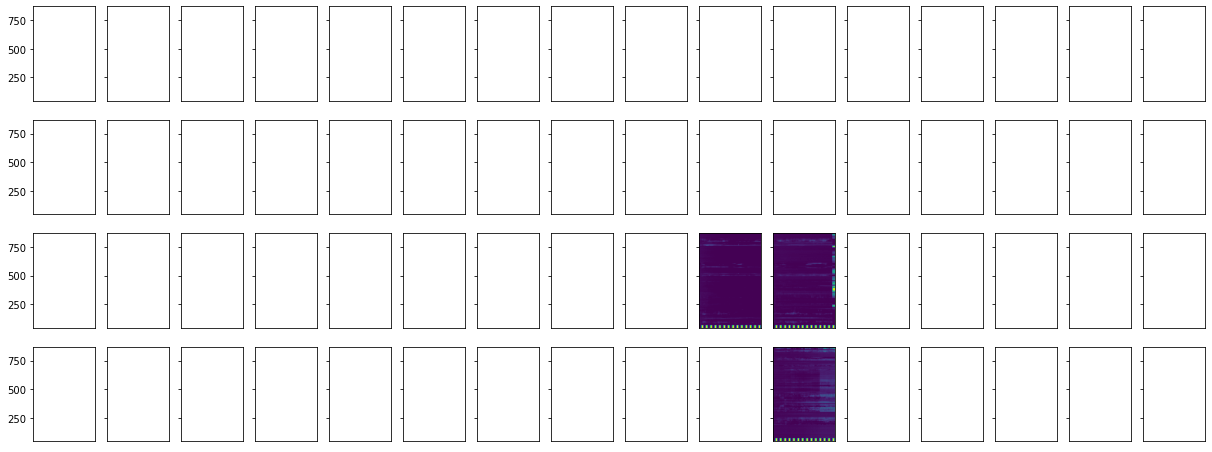

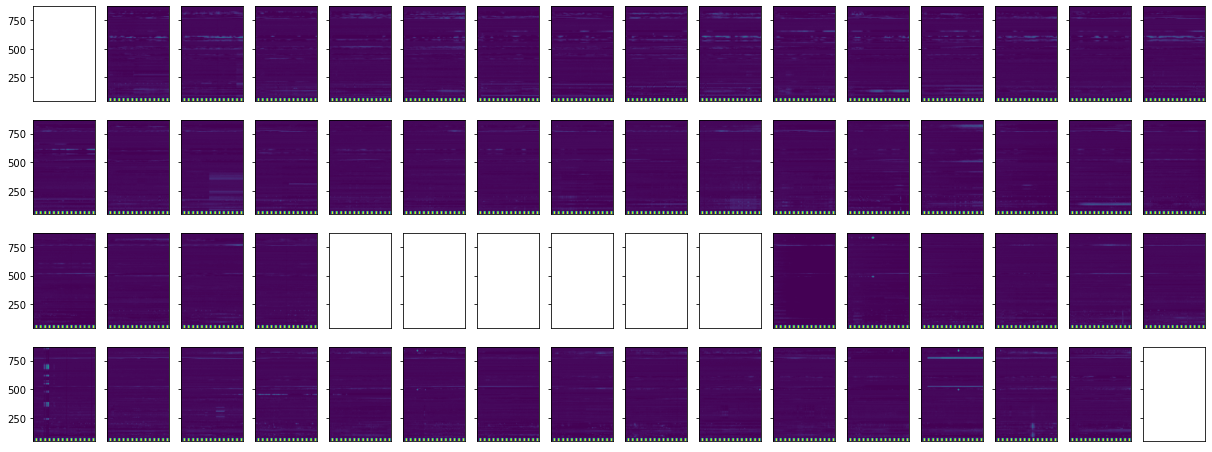

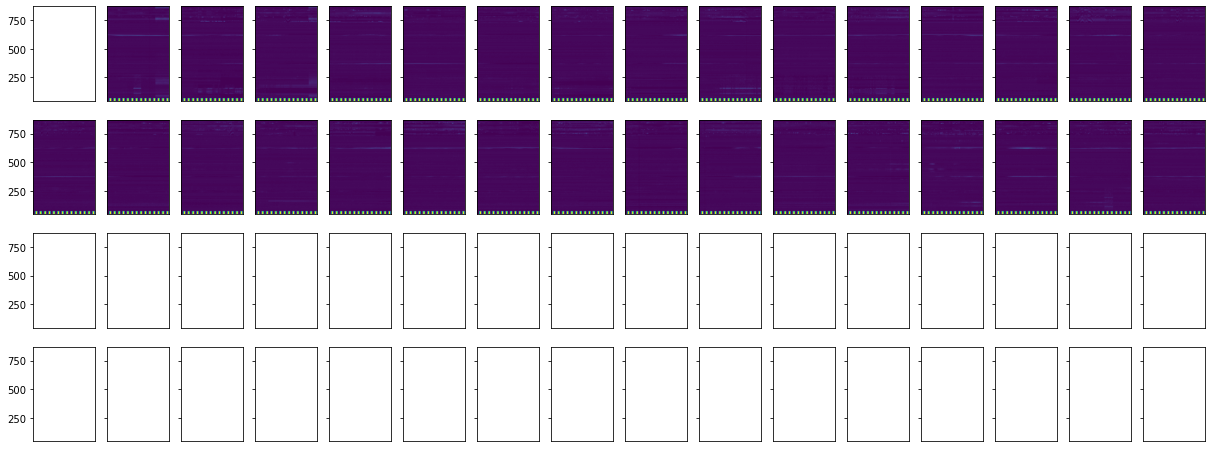

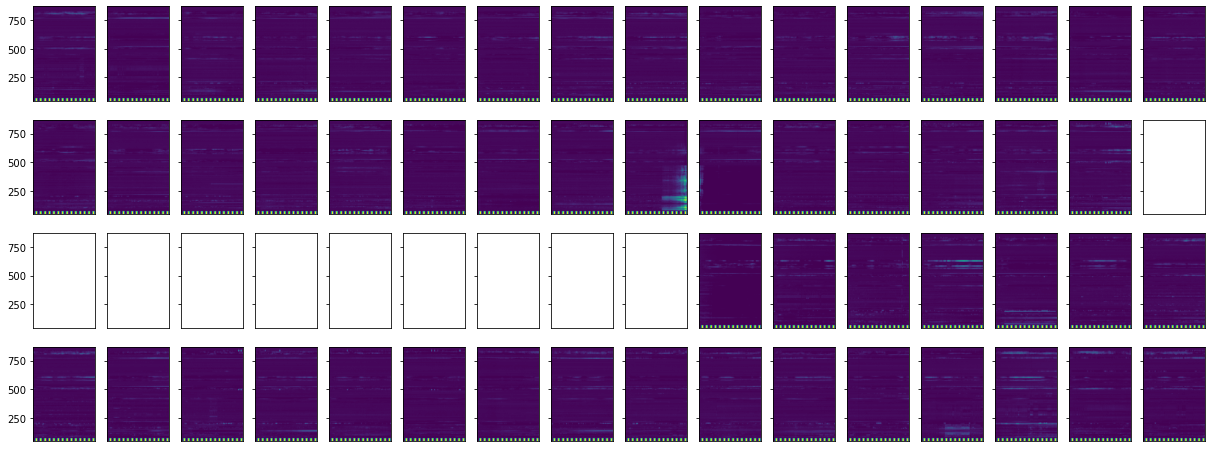

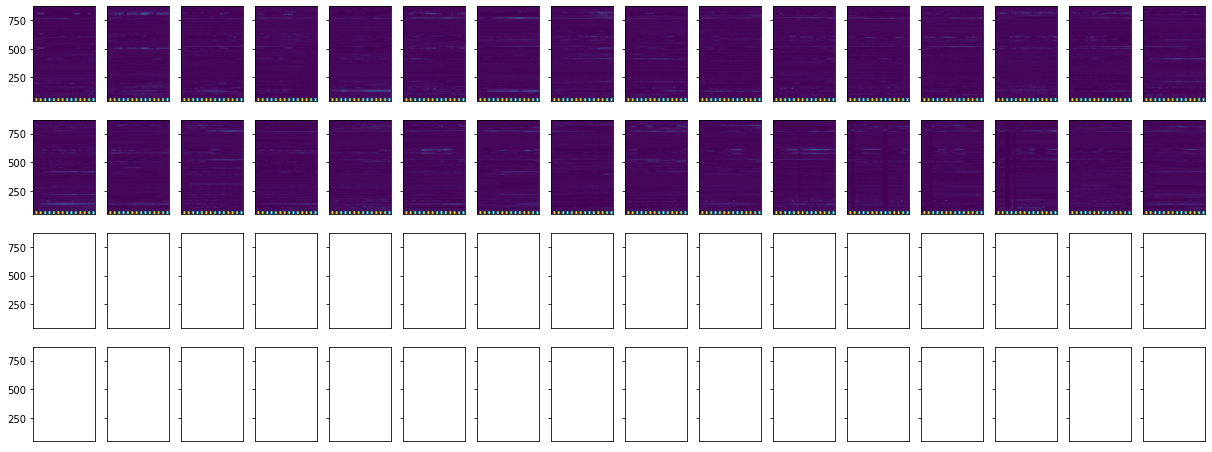

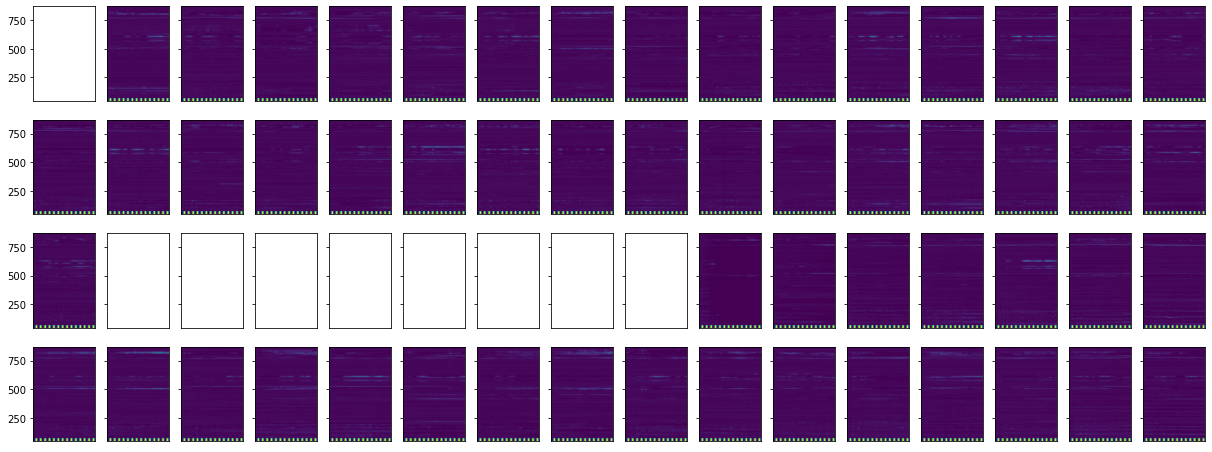

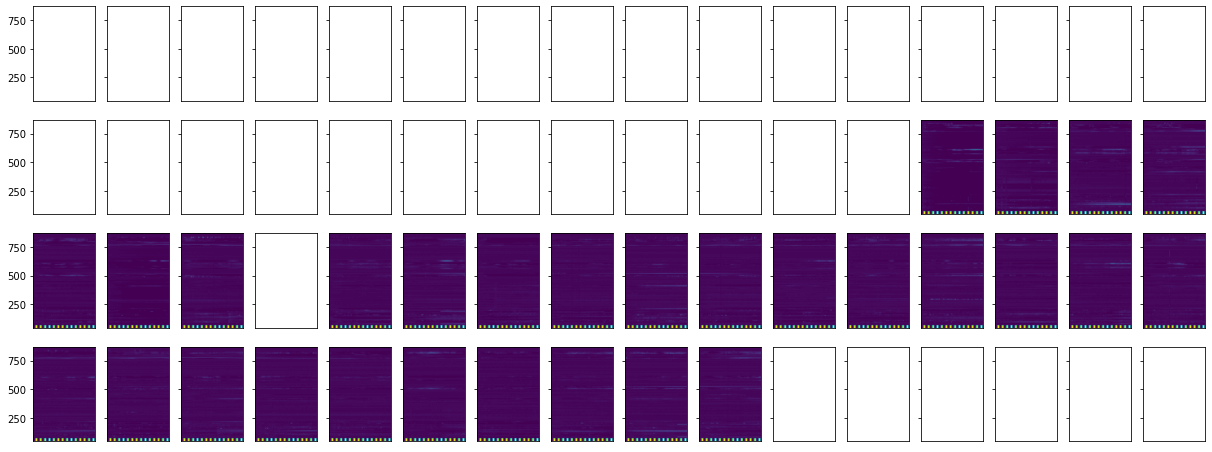

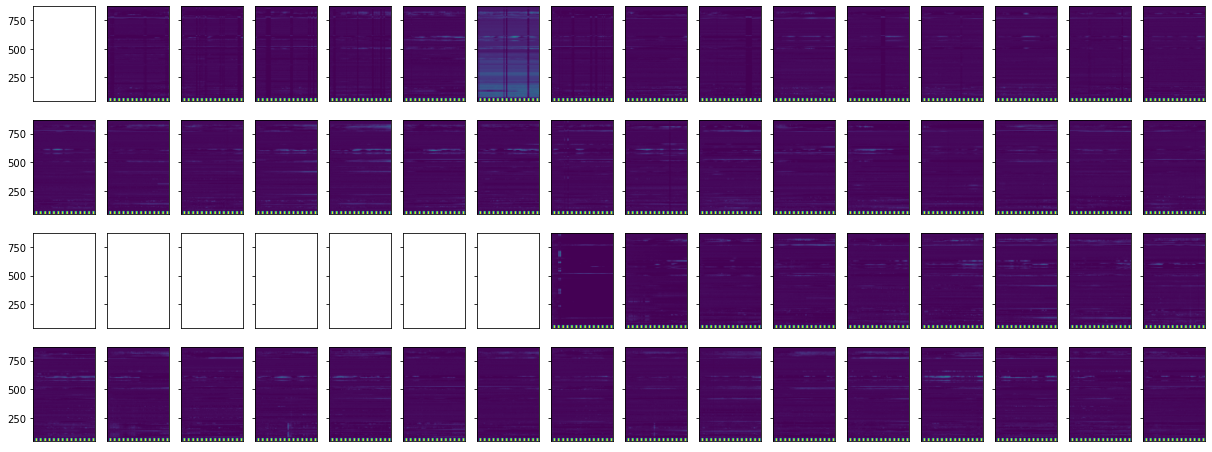

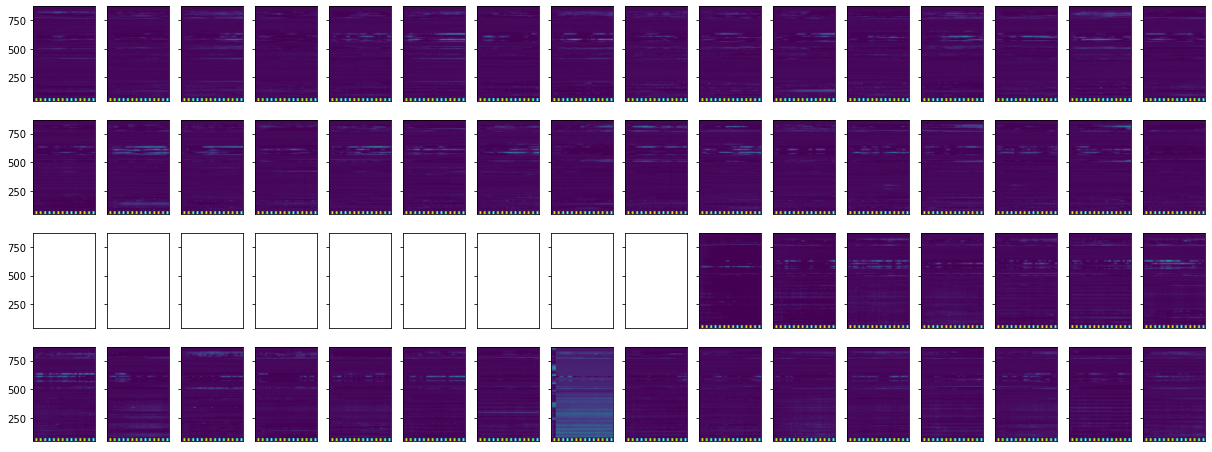

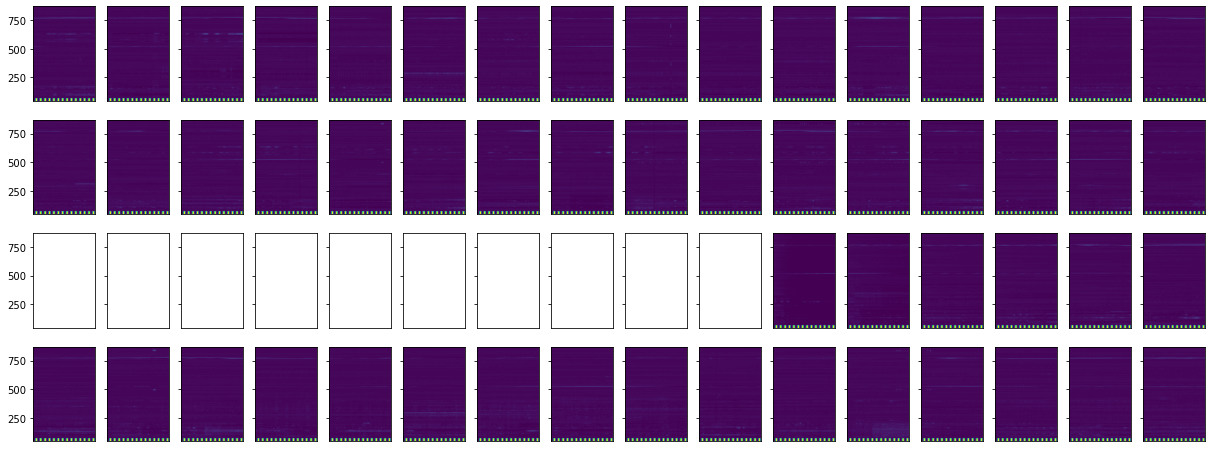

In [15]:
daily = Daily_Overview(**arguments)
list1 = daily.files()



In [ ]:
args = {
        "year" : 2022,
        "month" : 1,
        "day" : 1,
        "src" : "E:\\",
        "dst" : "E:/CALLISTO/"    
}
p = variables(**args)
copy_file = copy_files(p)
d , path = copy_file.date_range('01-01-2022','06-30-2022')
copy_file.folder_maker(d,path)

In [ ]:
#For Advancement------> 
# import tempfile
# import shutil
# def temp_dir():
#     with tempfile.TemporaryDirectory() as tmpdir:
# #         print('Created temporary directory ', tmpdir)
# #         os.path.exists(tmpdir)
#         src = "E:\\CALLISTO\\Daily_Overview\\2021\\2021-07-03\\MUPK_20210703_004500_59.fit"
#         dst = str(tmpdir)
#         shutil.copy(src, dst)
#         for root, dirs, files in os.walk(dst):
#             print(files,tmpdir)

        
# temp_dir()

In [ ]:
#Rename dir names wrt correct date format(YY,mm,dd)
#os.chdir(r"E:\\CALLISTO\\Daily_Overview\\01-01-2022_to_06-30-2022\\Data\\")
# liste = []
# print()
# for root, dirs, files in os.walk(os.getcwd()):
#             liste.append(dirs)
# # print(liste[0])
# df = pd.DataFrame(liste[0])
# liste = liste[0]
# df[0] = pd.to_datetime(df[0])
# df[0] = df[0].astype(str)
# for x in range (len(df)):
#     os.rename(liste[x],df[0][x])
 
# print(liste[1], df[0][1])